# Итоговый проект. Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг:
1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
•	Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
•	Выделенная линия технической поддержки (TechSupport);
•	Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
•	Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


## Загрузка файлов

In [ ]:
!gdown  --id 1OVOIuJGTfGr4MHjEF2EvagqyhAos70bA
!gdown  --id 1dzHlnnUqv42RHNN5zhwB_Z-2qXcOzZSU
!gdown  --id 1bMKJtjR9-tJNq48QNMlyMPbdkjVPSYAw
!gdown  --id 1Nj_zb-FK0kOCH9UaHPNNimI802f1nN73

Downloading...
From: https://drive.google.com/uc?id=1OVOIuJGTfGr4MHjEF2EvagqyhAos70bA
To: /content/phone.csv
100% 92.0k/92.0k [00:00<00:00, 1.44MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dzHlnnUqv42RHNN5zhwB_Z-2qXcOzZSU
To: /content/personal.csv
100% 182k/182k [00:00<00:00, 1.58MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bMKJtjR9-tJNq48QNMlyMPbdkjVPSYAw
To: /content/internet.csv
100% 221k/221k [00:00<00:00, 1.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Nj_zb-FK0kOCH9UaHPNNimI802f1nN73
To: /content/contract.csv
100% 546k/546k [00:00<00:00, 3.33MB/s]


In [ ]:
!pip install catboost

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split

#predective models
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#import metrics
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

#neural network
import tensorflow as tf
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

pd.options.mode.chained_assignment = None

## Исследовательский анализ данных

Чтение данных:

In [ ]:
contact = pd.read_csv('/content/contract.csv')
internet = pd.read_csv('/content/internet.csv')
personal = pd.read_csv('/content/personal.csv')
phone = pd.read_csv('/content/phone.csv')

### База контактов

Для начала поработаем с базой контактов.

In [ ]:
contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


CustomerID это объект, а не число, что не очень хорошо, но и по нему можно соединить несколько таблиц. Дата окончания договора - это целевой признак, который надо преобразовать к удобному виду (булевскому). Тип договора - категориальная переменная, ее тоже лучше преобрзовать. Безбумажный метод и вид оплаты - похожи на бесполезные признаки. Стоимость услуг и итоговая стоимость - это хорошие признаки, их оставим. Также добавлю признак, показывающий количество месяцев использования услуг абонентом.

Посмотрим на целевой признак и его введем.

In [ ]:
contact['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

В последние 4 месяца уходит примерно равное количество людей. Нам не сильно важно, когда они ушли, но важен сам факт ухода к конкурирующей фирме. Поэтому ответ Нет заменим на ноль, а все уходы на единицу. Это и будет наш целевой показатель для оценки модели.

In [ ]:
contact['Target'] = (contact['EndDate'] != 'No') * 1

Посмотрим на остальные признаки в датасете. Тип договора:

In [ ]:
print ('Количество пропусков в Типе договора:', contact['Type'].isna().sum())
print ('Виды договоров: \n', contact['Type'].value_counts())

Количество пропусков в Типе договора: 0
Виды договоров: 
 Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


Пропусков нет, лишних категорий тоже. Оставим эту переменную как есть, она категориальная, при необходимости пропустим ее через энкодер.

Сейчас посмотрим на суммарные траты, и потом введем дополнительный признак -- количество месяцев, которые абонент пользуется нашими услугами (TotalMonths).

In [ ]:
contact['TotalCharges'] = pd.to_numeric(contact['TotalCharges'], errors = 'coerce' )

In [ ]:
contact [contact['TotalCharges'].isna() == True ]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,0


Нецифровые значения заменены на Nan. У всех таких абонентов дата открытия договора - февраль 2020, а это значит, что суммарные затраты совпадают с тратами первого месяца, на что и заменю пропуски.

In [ ]:
contact['TotalCharges'] = contact['TotalCharges'].fillna(contact['MonthlyCharges'])
print ('Количество пропусков в TotalCharges', contact['TotalCharges'].isna().sum())

Количество пропусков в TotalCharges 0


Вводим новый признак - срок использования услуги. И удалим ненужные признаки такие как - PaperlessBilling, PaymentMethod, а также EndDate, поскольку его мы уже заменили на Таргет. Дату начала договора приведем к типу даты.

In [ ]:
contact['TotalMonths'] = (contact['TotalCharges'] / contact['MonthlyCharges'] ).round(2)
contact = contact.drop(['PaperlessBilling', 'PaymentMethod', 'EndDate'], axis =1)
contact['BeginDate'] = pd.to_datetime(contact['BeginDate'], format='%Y-%m-%d')

Год открытия договора вынесем в отдельный признак, он может быть важен на ряду с суммарным временем использования услуг, который посчитан через TotalCharge.

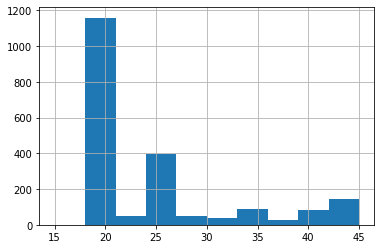

In [ ]:
contact['MonthlyCharges'].hist(range=(15,45))

In [ ]:
#contact['Year'] = pd.DatetimeIndex(contact['BeginDate']).year
contact['CatClient'] = contact['MonthlyCharges'] // contact['MonthlyCharges'].min()
contact['Basic'] = (contact['MonthlyCharges'] < 25) *1

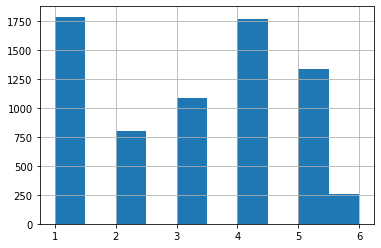

In [ ]:
contact['CatClient'].hist()

In [ ]:
contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customerID      7043 non-null   object        
 1   BeginDate       7043 non-null   datetime64[ns]
 2   Type            7043 non-null   object        
 3   MonthlyCharges  7043 non-null   float64       
 4   TotalCharges    7043 non-null   float64       
 5   Target          7043 non-null   int64         
 6   TotalMonths     7043 non-null   float64       
 7   CatClient       7043 non-null   float64       
 8   Basic           7043 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 495.3+ KB


In [ ]:
contact.duplicated().sum()

0

Дубликатов нет, сейчас посмотрим на распределения значений, чтобы оценить наличие аномалий.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84d442bc90>,
      dtype=object)

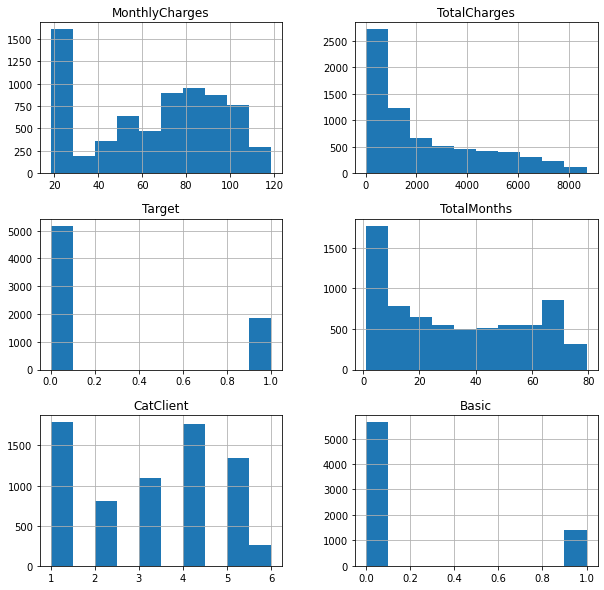

In [ ]:
contact.hist(figsize = (10,10))

В целом распределения не особо равномерные. Существенный всплеск значений MonthlyCharges в районе 20у.е. может быть обусловлен самым дешевым (и потому популярным) тарифом. Посмотрим на него внимательней. Суммарные затраты похожи на экспоненциальное распределение, что похоже на правду, а вот TotalMonths имеет очень странную структуру, со пиком околонулевых значений. Посмотрим на него потом.

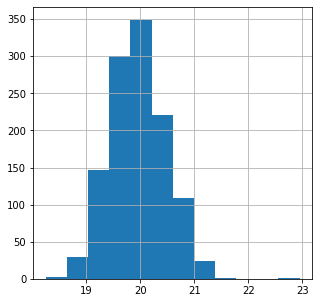

In [ ]:
contact[contact['MonthlyCharges'] <= 23]['MonthlyCharges'].hist(bins = 12, figsize = (5,5))

In [ ]:
print(contact [contact['MonthlyCharges'] < 20.5 ]['MonthlyCharges'].value_counts(ascending = False).head(10))

display(contact [contact['MonthlyCharges'] == 20].head())

20.05    61
19.85    45
19.95    44
19.90    44
19.70    43
20.00    43
19.65    43
20.15    40
19.55    40
19.75    39
Name: MonthlyCharges, dtype: int64


,customerID,BeginDate,Type,MonthlyCharges,TotalCharges,Target,TotalMonths,CatClient,Basic
213,4709-LKHYG,2017-09-01,One year,20.0,540.05,0,27.00,1.0,1
458,4237-CLSMM,2019-12-01,Month-to-month,20.0,38.00,0,1.90,1.0,1
584,2393-DIVAI,2019-11-01,Month-to-month,20.0,61.70,0,3.08,1.0,1
624,1009-IRMNA,2019-04-01,Month-to-month,20.0,137.60,1,6.88,1.0,1
798,3807-XHCJH,2020-01-01,Month-to-month,20.0,20.00,0,1.00,1.0,1


Похоже, что 20 у.е. это минимальный тариф, которое выбирает большинство абонентов. Поэтому всплекск есть, но его можно объяснить. Посмотрим сейчас на минимальный значения суммарных поступлений.

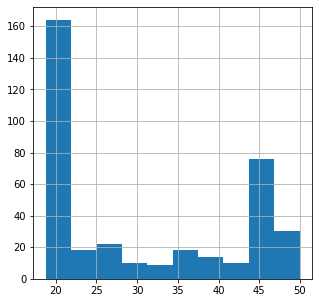

In [ ]:
contact[contact['TotalCharges'] <= 50]['TotalCharges'].hist(bins = 10, figsize = (5,5))

In [ ]:
contact[contact['TotalCharges'] <= 25]['TotalMonths'].value_counts()

1.0    182
Name: TotalMonths, dtype: int64

Люди, заплатившие до 25 у.е. пользуются услугами 1 месяц, это значит, что данные скорее верны, чем ошибочны. 

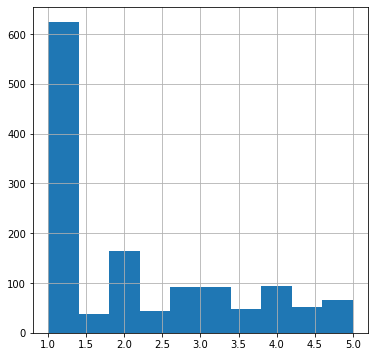

In [ ]:
contact['TotalMonths'].hist(range=(1,5), bins = 10, figsize = (6,6))

Очень много новичков. С первого месяца давать скидку это моветон, поэтому их вообще вычеркнем из базы данных, чтоб не нарушать отчетности. Вполне возможно, это вбросы, т.к. соседние месяцы сильно отличаются от первого. 

In [ ]:
contact = contact[contact['TotalMonths'] > 1].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84d3fda350>,
      dtype=object)

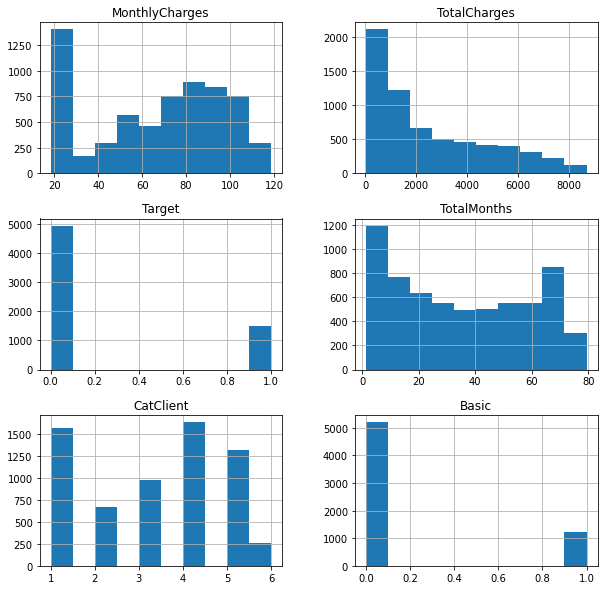

In [ ]:
contact.hist(figsize = (10,10))

Немного подсбаллансировали выборку, удалив тех, кто пользуется услугами менее 1 месяца. Старый друг лучше новых двух, поэтому сконцентрируем работу модели на клиентах, которые пришли не ради скидки, а ради услуг. 

In [ ]:
contact.describe()

,MonthlyCharges,TotalCharges,Target,TotalMonths,CatClient,Basic
count,6419.000000,6419.000000,6419.000000,6419.000000,6419.000000,6419.000000
mean,66.165010,2496.529195,0.231968,35.425009,3.192086,0.188191
std,30.198406,2259.936740,0.422121,23.635969,1.573788,0.390895
min,18.250000,27.550000,0.000000,1.410000,1.000000,0.000000
25%,39.650000,606.925000,0.000000,12.880000,2.000000,0.000000
50%,72.950000,1651.950000,0.000000,33.220000,3.000000,0.000000
75%,90.800000,4066.500000,0.000000,57.635000,4.000000,0.000000
max,118.750000,8684.800000,1.000000,79.340000,6.000000,1.000000


После обработки базы контактов данные выглядят так. Характерных вбросов нет,  максимальные и минимальные значения без аномалий. Можно переходить дальше.

### Персональные данные

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


Количество записей в персональных данных совпадает с их количеством в договорах, поэтому я планирую их объединить. Но сперва посмотрим. какие данные нам нужны. Пол человека - наверное, важный показатель, как и возраст. А вот партнер или иждивенец - тут всё не так очевидно. Посмотрим на них внимательней.

In [ ]:
personal['Partner'] = (personal['Partner'] == 'Yes') * 1
personal['Dependents'] = (personal['Dependents'] == 'Yes') * 1
personal['Female'] = (personal['gender'] == 'Female') * 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84d3cbd750>,
      dtype=object)

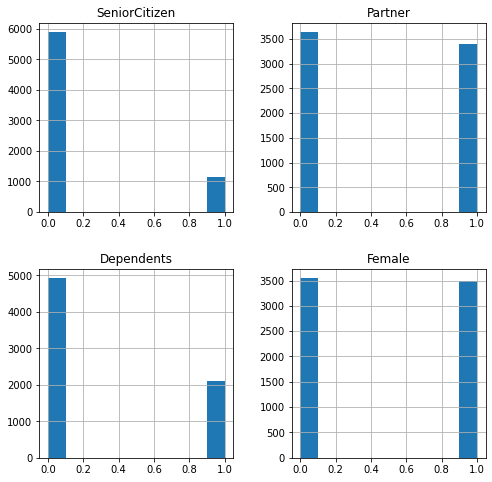

In [ ]:
personal.hist(figsize=(8,8))

In [ ]:
personal.corr(method = 'spearman')

,SeniorCitizen,Partner,Dependents,Female
SeniorCitizen,1.000000,0.016479,-0.211185,0.001874
Partner,0.016479,1.000000,0.452676,0.001808
Dependents,-0.211185,0.452676,1.000000,-0.010517
Female,0.001874,0.001808,-0.010517,1.000000


Корреляции между признаками особой нет. Надо либо все добавлять, либо все удалять. Я добавлю, будет обидно выкидывать признаки, которые могут оказаться полезными (а могут и не оказаться, тогда их удалим позже).

In [ ]:
personal =  personal.drop('gender', 1)
personal.head(2)

,customerID,SeniorCitizen,Partner,Dependents,Female
0,7590-VHVEG,0,1,0,1
1,5575-GNVDE,0,0,0,0


Объединим таблицы personal и contact в общую, с которой будем потом работать, таким образом, чтобы сохранились все данные из контактов, но не попали лишние.

In [ ]:
df = contact.merge (personal, on = 'customerID', how = 'left')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6419 entries, 0 to 6418
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customerID      6419 non-null   object        
 1   BeginDate       6419 non-null   datetime64[ns]
 2   Type            6419 non-null   object        
 3   MonthlyCharges  6419 non-null   float64       
 4   TotalCharges    6419 non-null   float64       
 5   Target          6419 non-null   int64         
 6   TotalMonths     6419 non-null   float64       
 7   CatClient       6419 non-null   float64       
 8   Basic           6419 non-null   int64         
 9   SeniorCitizen   6419 non-null   int64         
 10  Partner         6419 non-null   int64         
 11  Dependents      6419 non-null   int64         
 12  Female          6419 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(2)
memory usage: 702.1+ KB


Объединение прошло успешно, лишние значения не появились. Переходим далее.

### Телефон

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone['MultipleLines'] = (phone['MultipleLines'] == 'Yes') * 1

Тут только 1 параметр, но он не для всех пользователей. Видимо, те, кого тут нет, у них нет и телефона. Присоединим всех к уже существующей общей таблице. И добавим параметр Телефон, пропуски заменю на нули - нет телефона, нет мультилинии.

In [ ]:
df = df.merge(phone, on = 'customerID', how = 'left')

In [ ]:
df['Phone'] = (df['MultipleLines'].isna() == False) * 1
df['MultipleLines'] = df['MultipleLines'].fillna(0).astype('int')

In [ ]:
df.head(2)
#df.info()

,customerID,BeginDate,Type,MonthlyCharges,TotalCharges,Target,TotalMonths,CatClient,Basic,SeniorCitizen,Partner,Dependents,Female,MultipleLines,Phone
0,5575-GNVDE,2017-04-01,One year,56.95,1889.50,0,33.18,3.0,0,0,0,0,0,0,1
1,3668-QPYBK,2019-10-01,Month-to-month,53.85,108.15,1,2.01,2.0,0,0,0,0,0,0,1


Новый признак появлися, объединение прошло успешно. Осталось разобраться с интернетом.

### Интернет

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Тут ситуация аналогичная с телефоном. Заполнены не все кастомер ай-ди, значит у некоторых нет интренета (они пользуются только телеофном (надо будет проверить)), поэтому можно ввести еще один признак - Интренет. 

In [ ]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Нет уверенности. что доп услуги оказывают влияние на уходящих пользователей. Но все равно пока их оставим, а позже оценим важность этих признаков на итоговые предсказания модели.

In [ ]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [ ]:
cat_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cat_columns:
  internet[col] = (internet[col] == 'Yes') * 1

In [ ]:
df = df.merge( internet, on = 'customerID', how = 'left')

In [ ]:
print ('Проверка на дорогах')
print ('Количество пропусков в графе Интернет: ', df['InternetService'].isna().sum())
print ('Количество телефонов в без интернета: ', df[df['InternetService'].isna() == True]['Phone'].sum())

Проверка на дорогах
Количество пропусков в графе Интернет:  1354
Количество телефонов в без интернета:  1354


Всё сходится. Люди не имеющие интернета, имеют телефон. Но нектороые имеют и то и другое, поэтому интернет и телефон не будут взаимно коллинеарны.

In [ ]:
df['Internet'] = (df['InternetService'].isna() == False) * 1


Тут мы заменим получившиеся пропуски на нули. Они образовались, когда соединяли таблицы у тех, у кого был только телефон.

In [ ]:
df['InternetService'] = df['InternetService'].fillna(0)
for cat in cat_columns:
  df[cat] = df[cat].fillna(0)
  df[cat] = df[cat].astype ('int')

### Итоговые данные

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6419 entries, 0 to 6418
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        6419 non-null   object        
 1   BeginDate         6419 non-null   datetime64[ns]
 2   Type              6419 non-null   object        
 3   MonthlyCharges    6419 non-null   float64       
 4   TotalCharges      6419 non-null   float64       
 5   Target            6419 non-null   int64         
 6   TotalMonths       6419 non-null   float64       
 7   CatClient         6419 non-null   float64       
 8   Basic             6419 non-null   int64         
 9   SeniorCitizen     6419 non-null   int64         
 10  Partner           6419 non-null   int64         
 11  Dependents        6419 non-null   int64         
 12  Female            6419 non-null   int64         
 13  MultipleLines     6419 non-null   int64         
 14  Phone             6419 n

In [ ]:
df.head()

,customerID,BeginDate,Type,MonthlyCharges,TotalCharges,Target,TotalMonths,CatClient,Basic,SeniorCitizen,Partner,Dependents,Female,MultipleLines,Phone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet
0,5575-GNVDE,2017-04-01,One year,56.95,1889.50,0,33.18,3.0,0,0,0,0,0,0,1,DSL,1,0,1,0,0,0,1
1,3668-QPYBK,2019-10-01,Month-to-month,53.85,108.15,1,2.01,2.0,0,0,0,0,0,0,1,DSL,1,1,0,0,0,0,1
2,7795-CFOCW,2016-05-01,One year,42.30,1840.75,0,43.52,2.0,0,0,0,0,0,0,0,DSL,1,0,1,1,0,0,1
3,9237-HQITU,2019-09-01,Month-to-month,70.70,151.65,1,2.14,3.0,0,0,0,0,1,0,1,Fiber optic,0,0,0,0,0,0,1
4,9305-CDSKC,2019-03-01,Month-to-month,99.65,820.50,1,8.23,5.0,0,0,0,0,1,1,1,Fiber optic,0,0,1,0,1,1,1


**Вывод**

Данные подготовлены для обучения моделей. 
Осталось 3 столбца с типом 'object' - это ай-ди, тип договора и тип интренета. Для работы модели дата начала договора не нужна, есть дублирующие признак - год открытия договора и суммарное время (месяцы) пользования услугами. Целевой признак - Target. По нему будем вести предсказания. 

## Создание и обучение моделей

### Подготовка данных

Разобьем данные на обучающую и тестовую выборки в соотношениее 80-20%. Использовать валидационную не будем, т.к. большинство моделей работают с кросс-валидацией и сами сделают подвыборку из тестовой части. 

In [ ]:
features = df.drop(['customerID', 'BeginDate', 'Target'], axis = 1).copy()
target = df['Target'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=2021)

print ('Размер обучающей выборки: ', len(X_train))

print ('Размер тестовой выборки: ',len(X_test))

Размер обучающей выборки:  5135
Размер тестовой выборки:  1284


### Catboost

Зайдем с козырей - обучим категориальный бустинг и посмотрим важность признаков для него, чтобы последнующие модели могли обучаться на меньшем количестве данных.

In [ ]:
X_train.columns #для вывода категориальных переменных

Index(['Type', 'MonthlyCharges', 'TotalCharges', 'TotalMonths', 'CatClient',
       'Basic', 'SeniorCitizen', 'Partner', 'Dependents', 'Female',
       'MultipleLines', 'Phone', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Internet'],
      dtype='object')

In [ ]:
cat_features =['Type', 'SeniorCitizen', 'Partner', 'Dependents', 'Female', 'MultipleLines',
       'Phone', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Internet', 'Basic']

cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

In [ ]:
params = {'loss_function': 'Logloss',
          'eval_metric': 'AUC', 
          "verbose": False,
          'iterations' : 2000,
          'depth' : 4}

In [ ]:
scores = cv(cv_dataset,
            params,
            fold_count=3)

ROC-AUC при CV: 0.83758


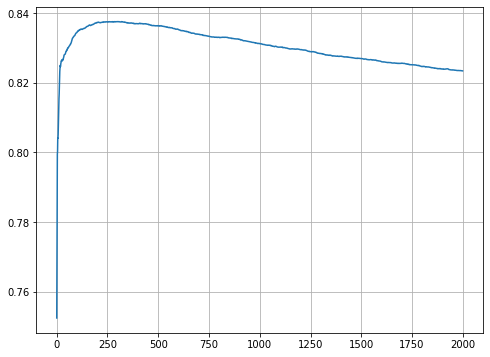

In [ ]:
print ('ROC-AUC при CV: {:.5f}'.format(scores['test-AUC-mean'].max()))
scores['test-AUC-mean'].plot(grid = True, figsize = (8,6))

### Оценка влияния признаков на итоговое предсказание модели

Запустим Кэтбуст без настроек для определения важных фичей

In [ ]:
cb = CatBoostClassifier(verbose=False, random_seed = 2021, eval_metric ='AUC', depth = 4)
cb.fit(X_train, y_train, eval_set=(X_test,y_test), cat_features = cat_features)

print('Важность признаков для итогового предсказания:')

range = pd.DataFrame (data = cb.get_feature_importance(), index = X_train.columns, columns = ['range'])
print (range.sort_values(by = 'range',ascending  = False))

Важность признаков для итогового предсказания:
                      range
Type              31.612286
TotalMonths       19.008114
MonthlyCharges    15.239033
InternetService   10.267449
Internet           9.674659
OnlineSecurity     3.095053
TechSupport        2.384408
TotalCharges       2.315304
StreamingTV        1.577029
SeniorCitizen      1.486738
MultipleLines      1.186995
StreamingMovies    1.158305
OnlineBackup       0.323838
Phone              0.291293
DeviceProtection   0.200907
Dependents         0.097155
Female             0.081435
Partner            0.000000


Не все введеные признаки оказались важны для работы модели. Например, наличие телефона или интренета практически не влияет на предсказание. А год заключения договора и длительность использования услуг, наоборот, оказались чуть ли не самыми важными признаками. 
Избавимся от наименее важных признаков (FI < 1.9) и посмотрим, как изменится предсказание модели.



In [ ]:
X_train_1 = X_train.copy()
X_train_1 = X_train_1.drop( ['SeniorCitizen','MultipleLines', 
                             'StreamingMovies', 'OnlineBackup', 'Phone',
                             'DeviceProtection', 'Dependents', 'Female' ,'Partner'
                             ], axis = 1)

X_test_1 = X_test.copy()
X_test_1 = X_test_1.drop( ['SeniorCitizen','MultipleLines', 
                             'StreamingMovies', 'OnlineBackup', 'Phone',
                             'DeviceProtection', 'Dependents', 'Female' ,'Partner'
                             ], axis = 1)

In [ ]:
X_train_1.columns

Index(['Type', 'MonthlyCharges', 'TotalCharges', 'TotalMonths',
       'InternetService', 'OnlineSecurity', 'TechSupport', 'StreamingTV',
       'Internet'],
      dtype='object')

In [ ]:
cat_features_1 = ['Type', 'StreamingTV', 'InternetService','OnlineSecurity', 
                  'TechSupport', 'Internet']

ROC-AUC при CV: 0.83702


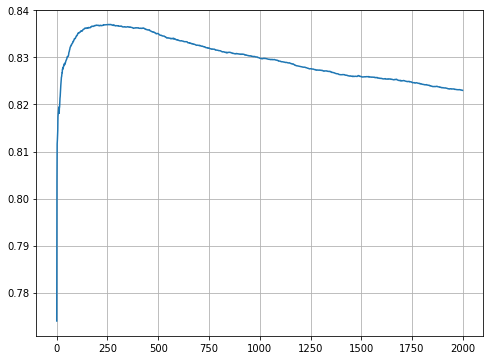

In [ ]:
cv_dataset_1 = Pool(data=X_train_1,
                  label=y_train,
                  cat_features=cat_features_1)

scores_1 = cv(cv_dataset_1,
            params,
            fold_count=3)

print ('ROC-AUC при CV: {:.5f}'.format(scores_1['test-AUC-mean'].max()))
scores_1['test-AUC-mean'].plot(grid = True, figsize = (8,6))

In [ ]:
cb_1 = CatBoostClassifier(verbose=False, random_seed = 2021, eval_metric ='AUC')

cb_1.fit(X_train_1, y_train, eval_set=(X_test_1,y_test), cat_features = cat_features_1)

cat_roc = cb_1.best_score_['validation']['AUC']
cat_acc = accuracy_score(y_test, cb_1.predict(X_test_1))
print('AUC valid: {:.5f}'.format(cat_roc))
print('Accuracy test: {:.5f}'.format(cat_acc))

Убрав фичи с важностью меньше 1,9, мы получили небольшой прирост метрики. Думаю, это предел для кэтбуста на этих данных - ROC-AUC = 0,86. Можно посмотреть теперь на менее сложные модели, такие как Логистическая регрессия, дерево решений и случайный лес. Для улучшения метрики, скорее всего, надо поиграться с фичами.

### Подготовка выборок для простых моделей

Для работы с более простыми моделями проведем дамми-кодирование признаков. Масштабирование будет использовать то, которое уже вложено в модель. Но сначала избавимся от ненужных фичей, определенных в предыдущем пункте.

In [ ]:
#создание dummy-признаков
X_train_dum = pd.get_dummies(X_train_1, drop_first=True)
X_test_dum = pd.get_dummies(X_test_1, drop_first=True)

In [ ]:
X_train_dum.head(2)

### Логистическая регрессия

In [ ]:
model_log = LogisticRegression(class_weight = 'balanced', solver = 'saga')

model_log.fit(X_train_dum, y_train)

proba_log_test = model_log.predict_proba(X_test_dum)
proba_log_1_test = proba_log_test[:, 1]

log_roc = roc_auc_score(y_test, proba_log_1_test)
log_acc = accuracy_score (y_test, model_log.predict(X_test_dum))  

print('LogisticRegression. Test ROC_AUC: {:.5f}'.format(log_roc))
print('LogisticRegression. Test Accuracy: {:.5f}'.format(log_acc))

### DecisionTree

In [ ]:
model_tree = DecisionTreeClassifier(random_state = 2021, class_weight='balanced')

param_grid_tree = {
    'max_depth' : [3,4,5,6,7,8],
    'min_samples_leaf' : [10,20,40,60,80,100,120,140,160,180,200],
    'max_leaf_nodes' : [6,8,10,12,14,16]
}

grid_tree = GridSearchCV(estimator = model_tree, param_grid = param_grid_tree, 
                         scoring = 'roc_auc', 
                         error_score='raise', cv=3
                         )
grid_tree.fit(X_train_dum, y_train)

print('Гиперпараметры модели:', grid_tree.best_params_)

proba_tree_test = grid_tree.predict_proba(X_test_dum)
proba_tree_1_test = proba_tree_test[:, 1]

tree_roc = roc_auc_score(y_test, proba_tree_1_test) 
tree_acc = accuracy_score (y_test, grid_tree.predict(X_test_dum))    

print('Tree. Test ROC_AUC: {:.5f}'.format(tree_roc))
print('Tree. Test Accuracy: {:.5f}'.format(tree_acc))

### RandomForest

In [ ]:
model_forest = RandomForestClassifier(random_state = 2021, class_weight='balanced')

param_grid_forest = {
    'max_depth' : [4, 6, 12, 24, 48, 96],
    'n_estimators': [60, 100, 150],
    'min_samples_leaf' : [4, 6, 8, 10, 12]
}

grid_forest = GridSearchCV(estimator = model_forest, param_grid = param_grid_forest, 
                         scoring = 'roc_auc', 
                         error_score='raise', cv = 3)

grid_forest.fit(X_train_dum, y_train)


print('Гиперпараметры модели:', grid_forest.best_params_)

proba_forest_test = grid_forest.predict_proba(X_test_dum)
proba_forest_1_test = proba_forest_test[:, 1]

forest_roc = roc_auc_score(y_test, proba_forest_1_test)
forest_acc = accuracy_score (y_test, grid_forest.predict(X_test_dum))   

print('Forest. Test ROC_AUC: {:.5f}'.format(forest_roc))
print('Forest. Test Accuracy: {:.5f}'.format(forest_acc))

### GradientBoosting

In [ ]:
model_clf = GradientBoostingClassifier (random_state = 2021)

param_grid_clf = {
    'max_depth' : [2, 3,4],
    'n_estimators': [20, 40, 60, 80],
    'min_samples_leaf' : [2, 4, 6],
    'learning_rate' : [0.1, 1]
}

grid_clf = GridSearchCV(estimator = model_clf, param_grid = param_grid_clf, 
                         scoring = 'roc_auc', 
                         error_score='raise', cv = 3)

grid_clf.fit(X_train_dum, y_train)


print('Гиперпараметры модели:', grid_clf.best_params_)

proba_clf_test = grid_clf.predict_proba(X_test_dum)
proba_clf_1_test = proba_clf_test[:, 1]

clf_roc = roc_auc_score(y_test, proba_clf_1_test)   
clf_acc = accuracy_score (y_test, grid_clf.predict(X_test_dum))

print('GBC. Test ROC_AUC: {:.5f}'.format(clf_roc))
print('GBC. Test Accuracy: {:.5f}'.format(clf_acc))

### Neural network

Для работы нейронной сети, надо опять подготовить данные.

In [ ]:
X = X_train_dum.values
Y = y_train.values

In [ ]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Трехслойная нейронная сеть показала себя весьма неплохо, а увеличение нейронов практически не улучшало резльтат. Поэтому для имеющихся данных сеть большая, но в общем смысле - маленькая.

In [ ]:
# создание модели нейронной сети
def create_baseline():
  opti_adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
  model = Sequential()
  model.add(Dense(12, input_dim=13, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opti_adam, 
                metrics=[tf.keras.metrics.AUC()])  
  return model

#расчет при выделении 10% в тестовую выборку
estimator = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results_roc = cross_validate(estimator, X, encoded_Y, cv=kfold,
                         scoring='roc_auc',
                         return_train_score=True)

results_acc = cross_validate(estimator, X, encoded_Y, cv=kfold,
                         scoring='accuracy',
                         return_train_score=True)

keras_roc = results_roc['test_score'].max()
keras_acc = results_acc['test_score'].max()

print('Среднее значение ROC_AUC {:.5f}'.format(results_roc['test_score'].mean()))
print('Наибольшее значение ROC_AUC {:.5f}'.format(keras_roc))
print('Наибольшее значение Accuracy {:.5f}'.format(keras_acc))

## Результат работы моделей

Подведем результаты работы моделей в одном месте, снабдив их графическим представлением. Сравнения с константной моделью не будет, т.к. при ней рок-аук будет 0,5. 

In [ ]:
summary = pd.DataFrame (index = ['Catboost', 'LogRegression', 'Tree', 'Forest',
                                 'GradientBoosting', 'KerasClassifier'],
                        data = {'ROC-AUC': [cat_roc, log_roc, tree_roc, 
                                forest_roc, clf_roc, keras_roc], 
                                'Accuracy': [cat_acc, log_acc, tree_acc, 
                                forest_acc, clf_acc, keras_acc]})

In [ ]:
summary.plot(grid = True, figsize = (8,6), title = 'ROC-AUC & Accuracy', kind = 'bar', 
             ylim = (0.65,0.9), alpha = 0.65, legend = True)

При таком наборе данных, отметку в 0,85 ROC_AUC преодолевает только категориальный бустинг, потом идет градиентный бустинг. Нейронная сеть себя показала не самым лучшим образом, наверное, поэтому ее обычно не используют для работы с таблицами.

Таким образом победа достается catboost. С долей правильных ответов (accuracy) в районе 82% можно быть уверенным, что наша телеком компания не обанкроитится. 

## Аномалии результата

Интересный эффект получается, если добавить к признакам - месяц заключения договора. По логике месяц никак не должен коррелироваться с целевым значением, но при таком раскладе обе метрики для бустинговых моделей устремляются вверх.

In [ ]:
df_m = df.copy()
df_m['Month'] = pd.DatetimeIndex(df_m['BeginDate']).month

In [ ]:
features_m = df_m.drop(['customerID', 'BeginDate', 'Target'], axis = 1)
target_m = df_m['Target']

X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(
    features_m, target_m, test_size=0.2, random_state=2021)

X_val_m, X_test_m, y_val_m, y_test_m = train_test_split(
    X_val_m, y_val_m, test_size=0.5, random_state=2021)

In [ ]:
cb_m = CatBoostClassifier(verbose=False, random_seed = 2021, eval_metric ='AUC')
cb_m.fit(X_train_m, y_train_m, eval_set=(X_val_m,y_val_m), cat_features = cat_features_1)
print('AUC valid: {:.5f}'.format(cb_m.best_score_['validation']['AUC']))
print('Accuracy test: {:.5f}'.format(accuracy_score(y_test_m, cb_m.predict(X_test_m))))

Удивительный результат. Посмотрим на корреляцию между призаками и целевым призаком. 

In [ ]:
print('Корреляция между целевым и прочими признакамиЖ')
print(df_m.corr().loc[:,'Target'].sort_values(ascending = False))

Сравним с важностью признаков для самой модели.

In [ ]:
range_month = pd.DataFrame (data = cb_m.get_feature_importance(), 
                            index = X_train_m.columns, 
                            columns = ['range_with_months'])
print (range_month.sort_values(by = 'range_with_months',ascending  = False))

Посмотрим на коллинеарность признаков - Месяц заключения договора и Суммарное время использования услуг.

In [ ]:
figure(figsize=(12, 6))
plt.scatter(x = df_m[df_m['Target'] == 0]['TotalMonths'], y = df_m[df_m['Target'] == 0]['Month'], alpha = 0.3, c = 'blue')
plt.scatter(x = df_m[df_m['Target'] == 1]['TotalMonths'], y = df_m[df_m['Target'] == 1]['Month'], alpha = 0.3, c = 'red')
plt.title("Связь времени использования услуг и месяца заключения договора")
plt.xlabel("Длительность использования услуг (мес)")
plt.ylabel("Месяц заключения договора")
plt.show()

Красным показаны ушедшие абоненты, синим - продолжающие использование услуг. Тут видно, что максимально уходят абоненты, пришедшие за последние 2 года, а те, кто пользуются услугами дольше, практически не уходят. 

Однако, корреляции между целевым признаком и месяцем открытия договора практически нет. Зато на модель месяц открытия договора вместе с суммарным временем использования услуг оказывает очень большое влияние и приводит к существенному росту метрик. 

Для меня загадка, почему месяц открытия договора оказывает такое сильное влияние на предсазание модели и задирает метрику ROC_AUC вверх до почти немыслимых значений. Похоже, на ошибку, но, рассуждая логически, я ее не нахожу. 

## Вывод

В результате работы была выбрана модель, дающая наибольшее значение целевой метрики, и максимальное значение точности предсказаний (для интерпретации выводов). Были проанализированы исходные данные и оптимизированы шесть моделей классификации. Во время работы с признаками, была выявлена интересная закономерность, дающая аномально высокий результат целевой метрики, который нуждается в дальнейшем анализе. 